<a href="https://colab.research.google.com/github/alien-cyber/Butterfly-classification/blob/main/butterfly_classification_Googlecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First lets download the dataset from kaggle

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY'] = 'your_kaggle_apikey'


In [ ]:
!kaggle datasets download -d bertcarremans/butterfly-images

  0% 0.00/14.2M [00:00<?, ?B/s]
100% 14.2M/14.2M [00:00<00:00, 153MB/s]


The downloaded data is in zip file to unzip it run the below code

In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/butterfly-images.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/butterfly')  # Replace 'destination_folder' with your

Lets viswalize the data

In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(3,4))
    xrange=range(1,3)

    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)
    plt.show()

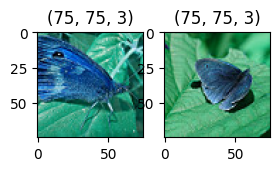

In [ ]:
load_images("/content/butterfly/butterflies/train/maniola_jurtina")

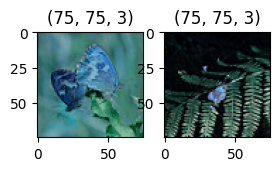

In [ ]:
load_images("/content/butterfly/butterflies/train/pyronia_tithonus")

below code will be used to plot graphs

In [ ]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')


    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

Resnet is an pretrained model,we will use it to extract the features of image

In [ ]:
from tensorflow.keras import layers, models,optimizers
from keras.optimizers import Adam


In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
model = models.Sequential()
model.add(ResNet50(include_top=False,pooling="max",weights='imagenet'))

model.add(layers.Dense(1,activation='sigmoid'))
model.layers[0].trainable=False
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
path_train = "/content/butterfly/butterflies/train"
files_train = os.listdir(path_train)

image_array_train=[]
label_array_train=[]
for i in range(len(files_train)):
  sub_file=os.listdir(path_train+'/'+files_train[i])
  for j in range(len(sub_file)):
    file_path=path_train+'/'+files_train[i]+'/'+sub_file[j]
    img=cv2.imread(file_path)

    image_array_train.append(img)
    label_array_train.append(i)
path_val = "/content/butterfly/butterflies/valid"
files_val = os.listdir(path_val)
image_array_val = []
label_array_val = []
for i in range(len(files_val)):
    sub_file = os.listdir(path_val + '/' + files_val[i])
    for j in range(len(sub_file)):
        file_path = path_val + '/' + files_val[i] + '/' + sub_file[j]
        img = cv2.imread(file_path)

        image_array_val.append(img)
        label_array_val.append(i)

In [ ]:
import numpy as np
image_array_train = np.array(image_array_train)
label_array_train = np.array(label_array_train)

image_array_val = np.array(image_array_val)
label_array_val = np.array(label_array_val)

In [ ]:
import tensorflow as tf
ckp_path = "trained_model/model"
os.makedirs(ckp_path, exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    monitor="val_mean_absolute_error",
    mode="auto",
    save_best_only=True,
    save_weights_only=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    factor = 0.9,
    monitor = "val_accuracy",
    mode = "auto",
    cooldown = 0,
    patience = 1,
    verbose = 1,
    min_lr = 1e-6
)


Epoch 1/50
27/29 [==========================>...] - ETA: 0s - loss: 0.5565 - accuracy: 0.7569

29/29 [==============================] - 6s 89ms/step - loss: 0.5548 - accuracy: 0.7567 - val_loss: 0.7788 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 2/50
27/29 [==========================>...] - ETA: 0s - loss: 0.5367 - accuracy: 0.7685

29/29 [==============================] - 1s 42ms/step - loss: 0.5303 - accuracy: 0.7700 - val_loss: 0.7657 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 3/50
27/29 [==========================>...] - ETA: 0s - loss: 0.5168 - accuracy: 0.7749

29/29 [==============================] - 1s 42ms/step - loss: 0.5171 - accuracy: 0.7739 - val_loss: 0.7630 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 4/50
27/29 [==========================>...] - ETA: 0s - loss: 0.5068 - accuracy: 0.7812


Epoch 4: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.5042 - accuracy: 0.7822 - val_loss: 0.7570 - val_accuracy: 0.6650 - lr: 1.0000e-04
Epoch 5/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4849 - accuracy: 0.7870

29/29 [==============================] - 1s 41ms/step - loss: 0.4937 - accuracy: 0.7856 - val_loss: 0.7618 - val_accuracy: 0.6783 - lr: 9.0000e-05
Epoch 6/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4834 - accuracy: 0.7812


Epoch 6: ReduceLROnPlateau reducing learning rate to 8.100000122794882e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.4833 - accuracy: 0.7817 - val_loss: 0.7519 - val_accuracy: 0.6583 - lr: 9.0000e-05
Epoch 7/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4729 - accuracy: 0.7928


Epoch 7: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.
29/29 [==============================] - 1s 41ms/step - loss: 0.4717 - accuracy: 0.7922 - val_loss: 0.7463 - val_accuracy: 0.6617 - lr: 8.1000e-05
Epoch 8/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4637 - accuracy: 0.7905

29/29 [==============================] - 1s 42ms/step - loss: 0.4631 - accuracy: 0.7928 - val_loss: 0.7431 - val_accuracy: 0.6800 - lr: 7.2900e-05
Epoch 9/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4575 - accuracy: 0.7957


Epoch 9: ReduceLROnPlateau reducing learning rate to 6.56100019114092e-05.
29/29 [==============================] - 1s 43ms/step - loss: 0.4566 - accuracy: 0.7950 - val_loss: 0.7431 - val_accuracy: 0.6717 - lr: 7.2900e-05
Epoch 10/50
29/29 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.8011

29/29 [==============================] - 1s 44ms/step - loss: 0.4496 - accuracy: 0.8011 - val_loss: 0.7402 - val_accuracy: 0.6850 - lr: 6.5610e-05
Epoch 11/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4530 - accuracy: 0.8003


Epoch 11: ReduceLROnPlateau reducing learning rate to 5.904900172026828e-05.
29/29 [==============================] - 1s 45ms/step - loss: 0.4497 - accuracy: 0.8017 - val_loss: 0.7432 - val_accuracy: 0.6700 - lr: 6.5610e-05
Epoch 12/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4337 - accuracy: 0.8038


Epoch 12: ReduceLROnPlateau reducing learning rate to 5.314410154824145e-05.
29/29 [==============================] - 1s 41ms/step - loss: 0.4382 - accuracy: 0.8028 - val_loss: 0.7349 - val_accuracy: 0.6767 - lr: 5.9049e-05
Epoch 13/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4362 - accuracy: 0.8050


Epoch 13: ReduceLROnPlateau reducing learning rate to 4.7829690083744934e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.4325 - accuracy: 0.8067 - val_loss: 0.7316 - val_accuracy: 0.6850 - lr: 5.3144e-05
Epoch 14/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4283 - accuracy: 0.8113


Epoch 14: ReduceLROnPlateau reducing learning rate to 4.304672074795235e-05.
29/29 [==============================] - 1s 41ms/step - loss: 0.4277 - accuracy: 0.8089 - val_loss: 0.7304 - val_accuracy: 0.6783 - lr: 4.7830e-05
Epoch 15/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4309 - accuracy: 0.8096

29/29 [==============================] - 1s 41ms/step - loss: 0.4280 - accuracy: 0.8111 - val_loss: 0.7297 - val_accuracy: 0.6883 - lr: 4.3047e-05
Epoch 16/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4142 - accuracy: 0.8131


Epoch 16: ReduceLROnPlateau reducing learning rate to 3.8742047036066654e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.4197 - accuracy: 0.8117 - val_loss: 0.7253 - val_accuracy: 0.6833 - lr: 4.3047e-05
Epoch 17/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4153 - accuracy: 0.8131


Epoch 17: ReduceLROnPlateau reducing learning rate to 3.4867842987296176e-05.
29/29 [==============================] - 1s 43ms/step - loss: 0.4177 - accuracy: 0.8128 - val_loss: 0.7259 - val_accuracy: 0.6800 - lr: 3.8742e-05
Epoch 18/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4195 - accuracy: 0.8113


Epoch 18: ReduceLROnPlateau reducing learning rate to 3.138105967082083e-05.
29/29 [==============================] - 1s 41ms/step - loss: 0.4140 - accuracy: 0.8156 - val_loss: 0.7238 - val_accuracy: 0.6850 - lr: 3.4868e-05
Epoch 19/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4131 - accuracy: 0.8160


Epoch 19: ReduceLROnPlateau reducing learning rate to 2.824295370373875e-05.
29/29 [==============================] - 1s 41ms/step - loss: 0.4119 - accuracy: 0.8178 - val_loss: 0.7229 - val_accuracy: 0.6867 - lr: 3.1381e-05
Epoch 20/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4038 - accuracy: 0.8177


Epoch 20: ReduceLROnPlateau reducing learning rate to 2.5418658333364876e-05.
29/29 [==============================] - 1s 44ms/step - loss: 0.4092 - accuracy: 0.8156 - val_loss: 0.7205 - val_accuracy: 0.6867 - lr: 2.8243e-05
Epoch 21/50
29/29 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8161


Epoch 21: ReduceLROnPlateau reducing learning rate to 2.2876792172610294e-05.
29/29 [==============================] - 1s 45ms/step - loss: 0.4067 - accuracy: 0.8161 - val_loss: 0.7201 - val_accuracy: 0.6883 - lr: 2.5419e-05
Epoch 22/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4114 - accuracy: 0.8125

29/29 [==============================] - 1s 42ms/step - loss: 0.4048 - accuracy: 0.8156 - val_loss: 0.7194 - val_accuracy: 0.6917 - lr: 2.2877e-05
Epoch 23/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3997 - accuracy: 0.8200


Epoch 23: ReduceLROnPlateau reducing learning rate to 2.0589113773894496e-05.
29/29 [==============================] - 1s 41ms/step - loss: 0.4035 - accuracy: 0.8189 - val_loss: 0.7182 - val_accuracy: 0.6917 - lr: 2.2877e-05
Epoch 24/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3979 - accuracy: 0.8229


Epoch 24: ReduceLROnPlateau reducing learning rate to 1.8530202396505047e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.4024 - accuracy: 0.8222 - val_loss: 0.7169 - val_accuracy: 0.6883 - lr: 2.0589e-05
Epoch 25/50
27/29 [==========================>...] - ETA: 0s - loss: 0.4057 - accuracy: 0.8166

29/29 [==============================] - 1s 41ms/step - loss: 0.4002 - accuracy: 0.8183 - val_loss: 0.7165 - val_accuracy: 0.6950 - lr: 1.8530e-05
Epoch 26/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3987 - accuracy: 0.8235

29/29 [==============================] - 1s 42ms/step - loss: 0.4002 - accuracy: 0.8233 - val_loss: 0.7162 - val_accuracy: 0.6967 - lr: 1.8530e-05
Epoch 27/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3944 - accuracy: 0.8194


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.667718133830931e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.3975 - accuracy: 0.8189 - val_loss: 0.7157 - val_accuracy: 0.6933 - lr: 1.8530e-05
Epoch 28/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3928 - accuracy: 0.8247


Epoch 28: ReduceLROnPlateau reducing learning rate to 1.5009462549642194e-05.
29/29 [==============================] - 1s 42ms/step - loss: 0.3961 - accuracy: 0.8239 - val_loss: 0.7158 - val_accuracy: 0.6950 - lr: 1.6677e-05
Epoch 29/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3968 - accuracy: 0.8229


Epoch 29: ReduceLROnPlateau reducing learning rate to 1.3508516622096067e-05.
29/29 [==============================] - 1s 43ms/step - loss: 0.3947 - accuracy: 0.8222 - val_loss: 0.7158 - val_accuracy: 0.6950 - lr: 1.5009e-05
Epoch 30/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3915 - accuracy: 0.8235


Epoch 30: ReduceLROnPlateau reducing learning rate to 1.2157664878031938e-05.
29/29 [==============================] - 1s 44ms/step - loss: 0.3937 - accuracy: 0.8228 - val_loss: 0.7163 - val_accuracy: 0.6967 - lr: 1.3509e-05
Epoch 31/50
29/29 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8244


Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0941898472083266e-05.
29/29 [==============================] - 1s 45ms/step - loss: 0.3928 - accuracy: 0.8244 - val_loss: 0.7156 - val_accuracy: 0.6950 - lr: 1.2158e-05
Epoch 32/50
29/29 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8256


Epoch 32: ReduceLROnPlateau reducing learning rate to 9.847708952293033e-06.
29/29 [==============================] - 1s 45ms/step - loss: 0.3919 - accuracy: 0.8256 - val_loss: 0.7154 - val_accuracy: 0.6950 - lr: 1.0942e-05
Epoch 33/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3942 - accuracy: 0.8281

29/29 [==============================] - 1s 43ms/step - loss: 0.3910 - accuracy: 0.8272 - val_loss: 0.7149 - val_accuracy: 0.7000 - lr: 9.8477e-06
Epoch 34/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3895 - accuracy: 0.8241


Epoch 34: ReduceLROnPlateau reducing learning rate to 8.862937647791114e-06.
29/29 [==============================] - 1s 43ms/step - loss: 0.3907 - accuracy: 0.8217 - val_loss: 0.7144 - val_accuracy: 0.7000 - lr: 9.8477e-06
Epoch 35/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3894 - accuracy: 0.8264


Epoch 35: ReduceLROnPlateau reducing learning rate to 7.976643883012003e-06.
29/29 [==============================] - 1s 43ms/step - loss: 0.3897 - accuracy: 0.8261 - val_loss: 0.7144 - val_accuracy: 0.6967 - lr: 8.8629e-06
Epoch 36/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3940 - accuracy: 0.8252


Epoch 36: ReduceLROnPlateau reducing learning rate to 7.178979740274372e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3893 - accuracy: 0.8272 - val_loss: 0.7140 - val_accuracy: 0.6983 - lr: 7.9766e-06
Epoch 37/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3827 - accuracy: 0.8299


Epoch 37: ReduceLROnPlateau reducing learning rate to 6.461081602537889e-06.
29/29 [==============================] - 1s 43ms/step - loss: 0.3887 - accuracy: 0.8250 - val_loss: 0.7138 - val_accuracy: 0.6983 - lr: 7.1790e-06
Epoch 38/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3862 - accuracy: 0.8264


Epoch 38: ReduceLROnPlateau reducing learning rate to 5.814973565065884e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3879 - accuracy: 0.8256 - val_loss: 0.7136 - val_accuracy: 0.6983 - lr: 6.4611e-06
Epoch 39/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3865 - accuracy: 0.8293


Epoch 39: ReduceLROnPlateau reducing learning rate to 5.233476167632034e-06.
29/29 [==============================] - 1s 41ms/step - loss: 0.3876 - accuracy: 0.8272 - val_loss: 0.7137 - val_accuracy: 0.6983 - lr: 5.8150e-06
Epoch 40/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3883 - accuracy: 0.8270


Epoch 40: ReduceLROnPlateau reducing learning rate to 4.710128632723354e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3871 - accuracy: 0.8283 - val_loss: 0.7135 - val_accuracy: 0.6983 - lr: 5.2335e-06
Epoch 41/50
29/29 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8256


Epoch 41: ReduceLROnPlateau reducing learning rate to 4.2391156057419724e-06.
29/29 [==============================] - 1s 45ms/step - loss: 0.3868 - accuracy: 0.8256 - val_loss: 0.7134 - val_accuracy: 0.6983 - lr: 4.7101e-06
Epoch 42/50
29/29 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8267


Epoch 42: ReduceLROnPlateau reducing learning rate to 3.815204127022298e-06.
29/29 [==============================] - 1s 45ms/step - loss: 0.3864 - accuracy: 0.8267 - val_loss: 0.7134 - val_accuracy: 0.6983 - lr: 4.2391e-06
Epoch 43/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3898 - accuracy: 0.8252


Epoch 43: ReduceLROnPlateau reducing learning rate to 3.4336838780291147e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3862 - accuracy: 0.8267 - val_loss: 0.7133 - val_accuracy: 0.6983 - lr: 3.8152e-06
Epoch 44/50
29/29 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8267


Epoch 44: ReduceLROnPlateau reducing learning rate to 3.09031540837168e-06.
29/29 [==============================] - 1s 43ms/step - loss: 0.3859 - accuracy: 0.8267 - val_loss: 0.7132 - val_accuracy: 0.6983 - lr: 3.4337e-06
Epoch 45/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3861 - accuracy: 0.8270


Epoch 45: ReduceLROnPlateau reducing learning rate to 2.781283887998143e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3856 - accuracy: 0.8267 - val_loss: 0.7131 - val_accuracy: 0.6983 - lr: 3.0903e-06
Epoch 46/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3893 - accuracy: 0.8252


Epoch 46: ReduceLROnPlateau reducing learning rate to 2.5031555196619593e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3854 - accuracy: 0.8272 - val_loss: 0.7130 - val_accuracy: 0.6983 - lr: 2.7813e-06
Epoch 47/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3877 - accuracy: 0.8270


Epoch 47: ReduceLROnPlateau reducing learning rate to 2.25283988584124e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3852 - accuracy: 0.8272 - val_loss: 0.7129 - val_accuracy: 0.6983 - lr: 2.5032e-06
Epoch 48/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3834 - accuracy: 0.8304


Epoch 48: ReduceLROnPlateau reducing learning rate to 2.0275559791116393e-06.
29/29 [==============================] - 1s 43ms/step - loss: 0.3850 - accuracy: 0.8272 - val_loss: 0.7129 - val_accuracy: 0.6983 - lr: 2.2528e-06
Epoch 49/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3844 - accuracy: 0.8287


Epoch 49: ReduceLROnPlateau reducing learning rate to 1.8248004835186294e-06.
29/29 [==============================] - 1s 42ms/step - loss: 0.3848 - accuracy: 0.8278 - val_loss: 0.7129 - val_accuracy: 0.6983 - lr: 2.0276e-06
Epoch 50/50
27/29 [==========================>...] - ETA: 0s - loss: 0.3885 - accuracy: 0.8258


Epoch 50: ReduceLROnPlateau reducing learning rate to 1.6423204556303972e-06.
29/29 [==============================] - 1s 43ms/step - loss: 0.3847 - accuracy: 0.8272 - val_loss: 0.7128 - val_accuracy: 0.6983 - lr: 1.8248e-06


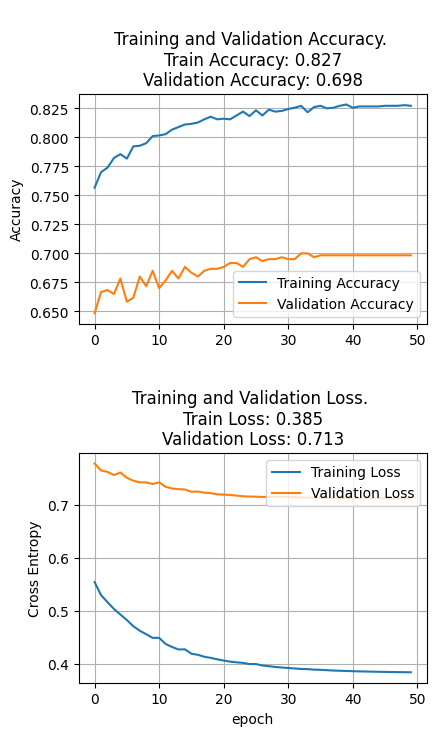

In [ ]:
learning_rate = 1e-4
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
Batch_Size=64
Epochs=50
history = model.fit(image_array_train, label_array_train, validation_data=(image_array_val,label_array_val), batch_size=Batch_Size, epochs=Epochs,callbacks=[model_checkpoint,reduce_lr] )
plot_history(history)